In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from copy import deepcopy
import scipy
from scipy.stats import pearsonr
from Bio import SeqIO
import os
import subprocess
from collections import Counter
%matplotlib inline

# Read metadata

In [2]:
df_meta = pd.read_csv('qiime2_output/SraRunTable.txt')
df_meta = df_meta[df_meta.project_name.str.contains('mouse')]
df_meta = df_meta[df_meta.sample_name.str.contains('D')]
df_meta = df_meta[['Run','sample_name','miscellaneous_parameter','organism_count']].rename({'miscellaneous_parameter':'Treatment','organism_count':'qPCR','sample_name':'SampleName'}, axis=1)
df_meta['Mouse'] = ['M'+str(x.split('.D')[0]) for x in df_meta.SampleName]
df_meta['Day'] = [int(x.split('.D')[1]) for x in df_meta.SampleName]
df_meta = df_meta.set_index('Run').sort_values(['Mouse','Day'])
df_meta.head()

,SampleName,Treatment,qPCR,Mouse,Day
Run,,,,,
ERR2539816,945451.D0,control,1.140000e+10,M945451,0
ERR2539817,945451.D1,control,6.280000e+09,M945451,1
ERR2539818,945451.D2,control,9.380000e+09,M945451,2
ERR2539819,945451.D3,control,9.470000e+09,M945451,3
ERR2539820,945451.D4,control,1.560000e+10,M945451,4


In [3]:
set(df_meta.Day)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}

In [4]:
len(set(df_meta[df_meta.Treatment=='control'].Mouse))

11

In [5]:
len(set(df_meta[df_meta.Treatment=='antibiotic'].Mouse))

10

# Read taxonomy data

In [6]:
df_tax = pd.read_csv('qiime2_output/taxonomy.tsv', sep="\t").rename({'Feature ID':'ASV'}, axis=1)
df_tax = df_tax[df_tax.Taxon.str.contains('d__Bacteria')]
df_tax = df_tax[~(df_tax.Taxon.str.contains('Chloroplast') | df_tax.Taxon.str.contains('Mitochondria'))]
df_tax['LowestTaxonomy'] = [t.split(';')[-1].strip() for t in df_tax.Taxon]
df_tax.head()

,ASV,Taxon,Confidence,LowestTaxonomy
0,d46e2205f0c6ecf67b51f83d111c509c,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,0.919473,g__Escherichia-Shigella
1,95fdd816723ca482a5caba10bea171c8,d__Bacteria; p__Firmicutes; c__Bacilli; o__Lac...,0.999987,g__Lactobacillus
2,72e530a4206f2e4804d502f4dfca8387,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,0.841709,s__uncultured_bacterium
3,cb8b8a6ee6bcfa115f8b24a45fa1c12a,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,0.958900,g__Muribaculaceae
4,9a13cbb8e1b12468bf22d6a05aafb0c0,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,0.978167,s__uncultured_bacterium


In [7]:
df_tax.iloc[3].Taxon

'd__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Bacteroidales; f__Muribaculaceae; g__Muribaculaceae'

In [8]:
df_tax.Confidence.min()

0.8006646910548355

# Read count data

In [9]:
df_count = pd.read_csv('qiime2_output/feature-table/feature-table.from_biom.txt', sep="\t", skiprows=[0], index_col=0)
df_count = df_count.loc[df_tax['ASV']].T
df_count = df_count.loc[df_count.sum(axis=1)[df_count.sum(axis=1)>=1000].index]
df_count = df_count.loc[:, (df_count != 0).any(axis=0)]
print("minimum seq depth = %d" % (df_count.sum(axis=1).min()))
df_relabun = df_count.div(df_count.sum(axis=1), axis=0)
df_relabun.head()

minimum seq depth = 1294


#OTU ID,d46e2205f0c6ecf67b51f83d111c509c,95fdd816723ca482a5caba10bea171c8,72e530a4206f2e4804d502f4dfca8387,cb8b8a6ee6bcfa115f8b24a45fa1c12a,9a13cbb8e1b12468bf22d6a05aafb0c0,bb7e5c6df18c100b97f890fc35eb2911,50524947f4796771e664e0e788ece0f3,99deb3c5ecb022ec05609ebd1112a557,4c2b64b57a4d0bf53cb325a4284bec4f,7b28c20e72c6c95b3e604f0849245770,...,921281a65a63f4671e133d65371e4c8d,cb7f4bcb022eeb720c89e9dc83ef1af6,9a8912f3788278e67f9ee6b0737b22e3,6b26e4126c7794043da4ea4895feebe8,9a59032ac6bd65925d0f67c759a32a3a,8ad3840c785a29203363098d6853ea52,b2b1d736975882921ad7631183f51cd9,fe0c746262de559cd371c49c62f8d2b7,105e68415c5685a8191f4687f7286b31,cf2fa51a927a4d62b052fd06d79605ed
ERR2539816,0.0,0.006011,0.042192,0.041959,0.202583,0.0,0.040486,0.067902,0.014310,0.013495,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERR2539817,0.0,0.035916,0.061878,0.059967,0.176475,0.0,0.078283,0.072549,0.022458,0.006132,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERR2539818,0.0,0.018425,0.057982,0.074733,0.238242,0.0,0.069965,0.073058,0.029893,0.004767,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERR2539819,0.0,0.012863,0.039716,0.127747,0.163983,0.0,0.058278,0.096083,0.026204,0.038454,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERR2539820,0.0,0.015377,0.062204,0.154093,0.101877,0.0,0.079021,0.010871,0.031172,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Plot dynamics of oral and gut bacteria

In [10]:
df_blast_100 = pd.read_csv("qiime2_output/asv-sequences/blast_fMOMD/blast_fMOMD_p100.txt", sep="\t", comment="#", header=None)
df_blast_100.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']
df_meta_oral = pd.merge(df_meta, df_relabun[list(set(df_blast_100.query_accver))].sum(axis=1).to_frame().rename({0:'OralFrac'}, axis=1), left_index=True, right_index=True)
df_meta_oral['qPCR_oral'] = df_meta_oral['qPCR']*df_meta_oral['OralFrac']
df_meta_oral['qPCR_gut'] = df_meta_oral['qPCR']*(1-df_meta_oral['OralFrac'])
df_meta_oral['log10_qPCR_oral'] = np.log10(df_meta_oral['qPCR_oral'])
df_meta_oral['log10_qPCR_gut'] = np.log10(df_meta_oral['qPCR_gut'])
df_meta_oral['log10_OralFrac'] = np.log10(df_meta_oral.OralFrac)
df_meta_oral['log10_qPCR'] = np.log10(df_meta_oral.qPCR)
df_meta_oral.head()

,SampleName,Treatment,qPCR,Mouse,Day,OralFrac,qPCR_oral,qPCR_gut,log10_qPCR_oral,log10_qPCR_gut,log10_OralFrac,log10_qPCR
ERR2539816,945451.D0,control,1.140000e+10,M945451,0,0.018963,2.161787e+08,1.118382e+10,8.334813,10.048590,-1.722092,10.056905
ERR2539817,945451.D1,control,6.280000e+09,M945451,1,0.048658,3.055730e+08,5.974427e+09,8.485115,9.776296,-1.312845,9.797960
ERR2539818,945451.D2,control,9.380000e+09,M945451,2,0.032212,3.021518e+08,9.077848e+09,8.480225,9.957983,-1.491978,9.972203
ERR2539819,945451.D3,control,9.470000e+09,M945451,3,0.027706,2.623734e+08,9.207627e+09,8.418920,9.964148,-1.557430,9.976350
ERR2539820,945451.D4,control,1.560000e+10,M945451,4,0.021881,3.413361e+08,1.525866e+10,8.533182,10.183517,-1.659942,10.193125


In [11]:
print("# control mice = %d" % (len(set(df_meta_oral[df_meta_oral.Treatment=='control'].Mouse))))
print("# control samples = %d" % (len(set(df_meta_oral[df_meta_oral.Treatment=='control'].SampleName))))
print("# abx treated mice = %d" % (len(set(df_meta_oral[df_meta_oral.Treatment=='antibiotic'].Mouse))))
print("# abx treated samples = %d" % (len(set(df_meta_oral[df_meta_oral.Treatment=='antibiotic'].SampleName))))

# control mice = 11
# control samples = 117
# abx treated mice = 10
# abx treated samples = 110


In [12]:
df_oral_tax = pd.merge(df_meta[df_meta.Treatment=='antibiotic'], df_relabun[list(set(df_blast_100.query_accver))], 
                       left_index=True, right_index=True, how='inner').drop(['SampleName','qPCR','Treatment'], axis=1).set_index(['Mouse','Day']).stack().reset_index()
df_oral_tax.columns = ['Mouse','Day','ASV','Fraction']
df_oral_tax = pd.merge(df_oral_tax, df_tax[['ASV','LowestTaxonomy']], left_on=['ASV'], right_on='ASV', how='inner')
df_oral_tax['ASV2'] = df_oral_tax['ASV']

print(set(df_oral_tax.sort_values('Fraction').tail(50).ASV))
df_oral_tax.loc[~df_oral_tax.ASV.isin(['d46e2205f0c6ecf67b51f83d111c509c', 'bb7e5c6df18c100b97f890fc35eb2911', '95fdd816723ca482a5caba10bea171c8']), 'ASV2'] = 'others'
df_oral_tax = df_oral_tax.groupby(['Mouse','Day','ASV2']).agg(np.sum).reset_index().sort_values('ASV2')
df_oral_tax = pd.pivot_table(data=df_oral_tax, index='Day', columns='ASV2', values='Fraction', aggfunc=np.mean)
df_oral_tax

{'bb7e5c6df18c100b97f890fc35eb2911', 'd46e2205f0c6ecf67b51f83d111c509c', '95fdd816723ca482a5caba10bea171c8'}


ASV2,95fdd816723ca482a5caba10bea171c8,bb7e5c6df18c100b97f890fc35eb2911,d46e2205f0c6ecf67b51f83d111c509c,others
Day,,,,
0,0.023779,0.000000,0.000498,0.017195
1,0.035098,0.000028,0.000389,0.012309
2,0.194040,0.081156,0.500173,0.002179
3,0.196708,0.116697,0.160988,0.019633
4,0.099921,0.133635,0.221686,0.013725
5,0.124245,0.095577,0.195464,0.012162
6,0.221525,0.023368,0.141084,0.025670
7,0.192950,0.273724,0.442097,0.000134
8,0.240691,0.297013,0.386213,0.000102


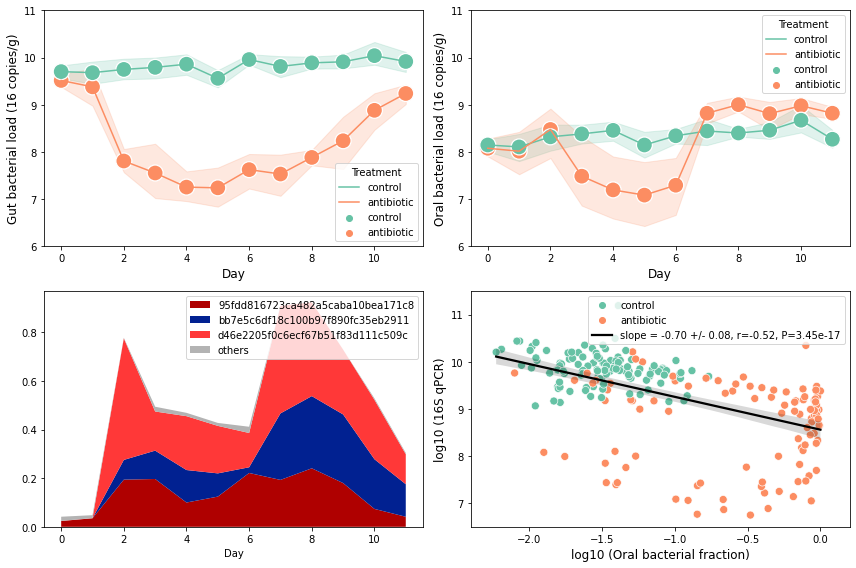

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

# dynamics of gut bacteria
_ = sns.lineplot(x="Day", y="log10_qPCR_gut", hue="Treatment", data=df_meta_oral, ax=ax[0,0], hue_order=['control','antibiotic'], palette='Set2')
_ = sns.scatterplot(x="Day", y="log10_qPCR_gut", hue="Treatment", data=df_meta_oral.groupby(['Treatment','Day'])['log10_qPCR_gut'].agg(np.mean).reset_index(), 
                    ax=ax[0,0], hue_order=['control','antibiotic'], s=256, palette='Set2')
_ = ax[0,0].set_xlabel('Day', fontsize=12)
_ = ax[0,0].set_ylabel('Gut bacterial load (16 copies/g)', fontsize=12)
#_ = ax[0,0].set_yscale('log')
_ = ax[0,0].set_ylim([6,11])

# dynamics of oral bacteria
_ = sns.lineplot(x="Day", y="log10_qPCR_oral", hue="Treatment", data=df_meta_oral, ax=ax[0,1], hue_order=['control','antibiotic'], palette='Set2')
_ = sns.scatterplot(x="Day", y="log10_qPCR_oral", hue="Treatment", data=df_meta_oral.groupby(['Treatment','Day'])['log10_qPCR_oral'].agg(np.mean).reset_index(), 
                    ax=ax[0,1], hue_order=['control','antibiotic'], s=256, palette='Set2')
_ = ax[0,1].set_xlabel('Day', fontsize=12)
_ = ax[0,1].set_ylabel('Oral bacterial load (16 copies/g)', fontsize=12)
#_ = ax[0,1].set_yscale('log')
_ = ax[0,1].set_ylim([6,11])

# dynamics of oral taxonomy
df_oral_tax = pd.merge(df_meta[df_meta.Treatment=='antibiotic'], df_relabun[list(set(df_blast_100.query_accver))], 
                       left_index=True, right_index=True, how='inner').drop(['SampleName','qPCR','Treatment'], axis=1).set_index(['Mouse','Day']).stack().reset_index()
df_oral_tax.columns = ['Mouse','Day','ASV','Fraction']
df_oral_tax = pd.merge(df_oral_tax, df_tax[['ASV','LowestTaxonomy']], left_on=['ASV'], right_on='ASV', how='inner')
df_oral_tax['ASV2'] = df_oral_tax['ASV']
df_oral_tax.loc[~df_oral_tax.ASV.isin(['d46e2205f0c6ecf67b51f83d111c509c', 'bb7e5c6df18c100b97f890fc35eb2911', '95fdd816723ca482a5caba10bea171c8']), 'ASV2'] = 'others'
df_oral_tax = df_oral_tax.groupby(['Mouse','Day','ASV2']).agg(np.sum).reset_index().sort_values('ASV2')
df_oral_tax = pd.pivot_table(data=df_oral_tax, index='Day', columns='ASV2', values='Fraction', aggfunc=np.mean)

to_stack = []
for taxon in df_oral_tax.columns:
    to_stack.append(list(df_oral_tax[taxon]))
_ = ax[1,0].stackplot(df_oral_tax.index, to_stack, 
                      colors = ['#af0000','#012191','#ff3838']+[sns.color_palette("Set2")[7]], 
                      labels=df_oral_tax.columns)
_ = ax[1,0].set_xlabel('Day')
_ = ax[1,0].legend()

# oral fraction vs qPCR
_ = sns.scatterplot(x="log10_OralFrac", y="log10_qPCR", data=df_meta_oral, ax=ax[1,1], s=64, hue='Treatment',palette='Set2')
fit = scipy.stats.linregress(x=df_meta_oral.log10_OralFrac, y=df_meta_oral.log10_qPCR)
corr = pearsonr(x=df_meta_oral.log10_OralFrac, y=df_meta_oral.log10_qPCR)
_ = sns.regplot(x="log10_OralFrac", y="log10_qPCR", data=df_meta_oral, ax=ax[1,1], color='k', scatter=False, label='slope = %2.2f +/- %2.2f, r=%2.2f, P=%2.2e' % (fit.slope, fit.stderr, corr[0], corr[1]))
_ = ax[1,1].legend()
_ = ax[1,1].set_xlabel('log10 (Oral bacterial fraction)', fontsize=12)
_ = ax[1,1].set_ylabel('log10 (16S qPCR)', fontsize=12)
_ = ax[1,1].set_xlim([-2.4,0.2])
_ = ax[1,1].set_ylim([6.5,11.5])

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("Reese_2018elife.svg", dpi=600, bbox_inches='tight')

In [14]:
df_meta_oral[df_meta_oral.Treatment=='antibiotic'].groupby('Day')['log10_qPCR_gut'].agg(np.mean)

Day
0     9.514493
1     9.378274
2     7.806722
3     7.552332
4     7.253148
5     7.237344
6     7.623613
7     7.530347
8     7.882496
9     8.236124
10    8.881120
11    9.238618
Name: log10_qPCR_gut, dtype: float64

In [15]:
10**(9.514-7.237)

189.2343618644972

In [16]:
df_meta_oral[df_meta_oral.Treatment=='antibiotic'].groupby('Day')['log10_qPCR_oral'].agg(np.mean)

Day
0     8.076655
1     8.013811
2     8.475429
3     7.484816
4     7.193475
5     7.083254
6     7.293048
7     8.819157
8     9.001935
9     8.811052
10    8.978634
11    8.819639
Name: log10_qPCR_oral, dtype: float64

In [17]:
10**(8.475-7.083)

24.66039337234336

In [14]:
df_tax[df_tax.ASV.isin(['d46e2205f0c6ecf67b51f83d111c509c', 'bb7e5c6df18c100b97f890fc35eb2911', '95fdd816723ca482a5caba10bea171c8'])]

,ASV,Taxon,Confidence,LowestTaxonomy
0,d46e2205f0c6ecf67b51f83d111c509c,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,0.919473,g__Escherichia-Shigella
1,95fdd816723ca482a5caba10bea171c8,d__Bacteria; p__Firmicutes; c__Bacilli; o__Lac...,0.999987,g__Lactobacillus
5,bb7e5c6df18c100b97f890fc35eb2911,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,0.942325,g__Proteus


In [15]:
fit = scipy.stats.linregress(x=df_meta_oral[df_meta_oral.Treatment=='control'].log10_OralFrac, y=df_meta_oral[df_meta_oral.Treatment=='control'].log10_qPCR)
corr = pearsonr(x=df_meta_oral[df_meta_oral.Treatment=='control'].log10_OralFrac, y=df_meta_oral[df_meta_oral.Treatment=='control'].log10_qPCR)
print('slope = %2.2f +/- %2.2f, r=%2.2f, P=%2.2e' % (fit.slope, fit.stderr, corr[0], corr[1]))

slope = -0.28 +/- 0.10, r=-0.25, P=5.89e-03


In [16]:
len(df_meta_oral[(df_meta_oral.log10_qPCR<8.5) & (df_meta_oral.log10_OralFrac < -0.25)])/len(df_meta_oral)

0.10572687224669604

# Are they oral if we relax the threshold?

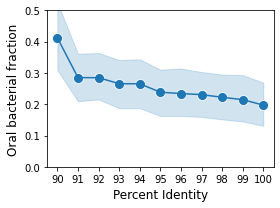

In [17]:
outliers = list(df_meta_oral[(df_meta_oral.log10_qPCR<8.5) & (df_meta_oral.log10_OralFrac < -0.25)].index)
df_relabun_outlier = df_relabun.loc[outliers]
df_relabun_outlier = df_relabun_outlier.loc[:, (df_relabun_outlier != 0).any(axis=0)]

df_outliers = pd.merge(df_tax[['ASV','LowestTaxonomy']].set_index('ASV'), 
                       df_relabun_outlier.T.mean(axis=1).sort_values().to_frame().rename({0:'MeanRelAbundance'}, axis=1),
                       left_index=True, 
                       right_index=True,
                       how='right').sort_values('MeanRelAbundance',ascending=False)
df_outliers = df_outliers[df_outliers.MeanRelAbundance >0.01]

seq_length_dict = {}
fasta_sequences = SeqIO.parse(open("qiime2_output/asv-sequences/dna-sequences.fasta"),'fasta')
with open("potential_misclassified_asvs.fasta", "w") as out_file:
    for fasta in fasta_sequences:
        name, sequence = fasta.id, str(fasta.seq)
        if name in list(df_outliers.index):
            out_file.write(">%s\n%s\n"%(name, sequence))
            seq_length_dict[name] = len(sequence)

#test if relaxing percent identity will predict more oral bacteria
df_res= None
for pident in [90,91,92,93,94,95,96,97,98,99,100]:
    df_blast = pd.read_csv("qiime2_output/asv-sequences/blast_fMOMD/blast_fMOMD_p%d.txt"%(pident), sep="\t", comment="#", header=None)
    df_blast.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']
    if df_res is None:
        df_res = deepcopy(df_relabun_outlier[list(set(df_blast.query_accver).intersection(df_relabun_outlier.columns))].sum(axis=1).to_frame().rename({0:pident}, axis=1))
    else:
        df_res = pd.merge(df_res, 
                          df_relabun_outlier[list(set(df_blast.query_accver).intersection(df_relabun_outlier.columns))].sum(axis=1).to_frame().rename({0:pident}, axis=1),
                          left_index=True,
                          right_index=True,
                          how='inner')
        
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,3))

df_res2 = df_res.stack().reset_index()
df_res2.columns = ['SampleID','Cutoff','OralFrac']
_ = sns.lineplot(x="Cutoff", y="OralFrac", data=df_res2, ax=ax)
_ = sns.scatterplot(x="Cutoff", y="OralFrac", data=df_res2.groupby(['Cutoff'])['OralFrac'].agg(np.mean).reset_index(), ax=ax, s=100)
_ = ax.set_xticks(np.arange(90,101))
_ = ax.set_ylim([0,0.5])
#_ = ax.set_yticklabels([r'$10^{%s}$'%(x) for x in [-3,-2,-1,0]])
_ = ax.set_xlabel('Percent Identity', fontsize=12)
_ = ax.set_ylabel('Oral bacterial fraction', fontsize=12)

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("relax_perc_identity.svg", dpi=600, bbox_inches='tight')


# Blast against NT database

In [18]:
df_blast_nt = pd.read_csv("EBZRVC6U016-Alignment.txt", sep="\t", comment="#", header=None)
df_blast_nt.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']
df_blast_nt = df_blast_nt[df_blast_nt.query_accver.isin(seq_length_dict.keys())]
indices_to_keep = []
for k,v in seq_length_dict.items():
    curr_df = df_blast_nt[df_blast_nt.query_accver==k]
    curr_df = curr_df[(curr_df.perc_identity==100) & (curr_df.alignment_length==v) & (curr_df.gap_opens==0) & (curr_df.mismatches==0) & (curr_df.sstart < 2000) & (curr_df.send < 2000)] # full length alignment
    if len(curr_df)>0:
        indices_to_keep.extend(list(curr_df.index))
df_blast_nt_filtered = df_blast_nt.loc[indices_to_keep]
print("%d out of %d sequences have 100 matches." % (len(set(df_blast_nt_filtered.query_accver)), len(seq_length_dict.keys())))
print("total NCBI entries = %d" % len(df_blast_nt_filtered))

17 out of 19 sequences have 100 matches.
total NCBI entries = 20628


# Color the samples by their sample collection day

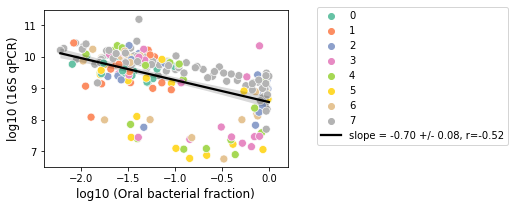

In [19]:
fig, ax = plt.subplots(figsize=(7.5,3))

df_meta_oral2 = deepcopy(df_meta_oral)
df_meta_oral2.loc[df_meta_oral.Day>=7, 'Day'] = 7
_ = sns.scatterplot(x="log10_OralFrac", y="log10_qPCR", data=df_meta_oral2, ax=ax, s=64, hue='Day',palette='Set2')
fit = scipy.stats.linregress(x=df_meta_oral.log10_OralFrac, y=df_meta_oral.log10_qPCR)
corr = pearsonr(x=df_meta_oral.log10_OralFrac, y=df_meta_oral.log10_qPCR)
_ = sns.regplot(x="log10_OralFrac", y="log10_qPCR", data=df_meta_oral, ax=ax, color='k', scatter=False, label='slope = %2.2f +/- %2.2f, r=%2.2f' % (fit.slope, fit.stderr, corr[0]))
_ = ax.legend()
_ = ax.set_xlabel('log10 (Oral bacterial fraction)', fontsize=12)
_ = ax.set_ylabel('log10 (16S qPCR)', fontsize=12)
_ = ax.set_xlim([-2.4,0.2])
_ = ax.set_ylim([6.5,11.5])

_ = ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("Reese_2018elife_linear_relat_color_by_day.svg", dpi=600, bbox_inches='tight')

# Color the samples by their dominant genus

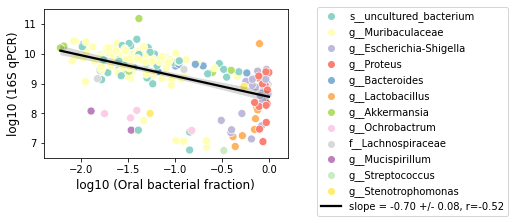

In [20]:
fig, ax = plt.subplots(figsize=(7.5,3))

df_meta_oral2 = deepcopy(df_meta_oral)
df2_relabun = df_relabun.stack().reset_index()
df2_relabun.columns = ['SampleID', 'ASV', 'Relabun']
df2_relabun = pd.merge(df2_relabun, df_tax[['ASV','LowestTaxonomy']], left_on='ASV', right_on='ASV', how='inner')
df2_relabun = df2_relabun.groupby(['SampleID','LowestTaxonomy']).agg(np.sum).reset_index()
df2_relabun = df2_relabun.sort_values(['SampleID','Relabun'], ascending=False)
df2_relabun = df2_relabun.drop_duplicates(subset='SampleID', keep='first').set_index('SampleID')
df_meta_oral2 = pd.merge(df_meta_oral2, df2_relabun, left_index=True, right_index=True, how='inner')

_ = sns.scatterplot(x="log10_OralFrac", y="log10_qPCR", data=df_meta_oral2, ax=ax, s=64, hue='LowestTaxonomy',palette='Set3')
fit = scipy.stats.linregress(x=df_meta_oral.log10_OralFrac, y=df_meta_oral.log10_qPCR)
corr = pearsonr(x=df_meta_oral.log10_OralFrac, y=df_meta_oral.log10_qPCR)
_ = sns.regplot(x="log10_OralFrac", y="log10_qPCR", data=df_meta_oral, ax=ax, color='k', scatter=False, label='slope = %2.2f +/- %2.2f, r=%2.2f' % (fit.slope, fit.stderr, corr[0]))
_ = ax.legend()
_ = ax.set_xlabel('log10 (Oral bacterial fraction)', fontsize=12)
_ = ax.set_ylabel('log10 (16S qPCR)', fontsize=12)
_ = ax.set_xlim([-2.4,0.2])
_ = ax.set_ylim([6.5,11.5])

_ = ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("Reese_2018elife_linear_relat_color_by_dominant_genus.svg", dpi=600, bbox_inches='tight')

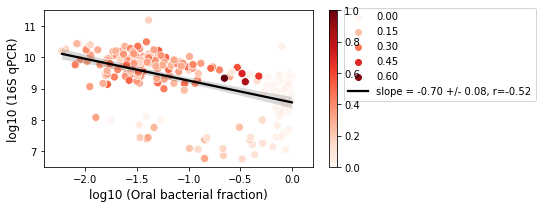

In [21]:
fig, ax = plt.subplots(figsize=(7.5,3))

df_meta_oral2 = deepcopy(df_meta_oral)
df_meta_oral2 = pd.merge(df_meta_oral2, df_relabun[list(df_tax[df_tax.Taxon.str.contains('uncultured')].ASV)].sum(axis=1).to_frame().rename({0:'Uncultured'},axis=1),
                         left_index=True, right_index=True, how='inner')
_ = sns.scatterplot(x="log10_OralFrac", y="log10_qPCR", data=df_meta_oral2, ax=ax, s=64, hue='Uncultured',palette='Reds')
norm = plt.Normalize(0,1)
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
sm.set_array([])

fit = scipy.stats.linregress(x=df_meta_oral.log10_OralFrac, y=df_meta_oral.log10_qPCR)
corr = pearsonr(x=df_meta_oral.log10_OralFrac, y=df_meta_oral.log10_qPCR)
_ = sns.regplot(x="log10_OralFrac", y="log10_qPCR", data=df_meta_oral, ax=ax, color='k', scatter=False, label='slope = %2.2f +/- %2.2f, r=%2.2f' % (fit.slope, fit.stderr, corr[0]))
_ = ax.legend()
_ = ax.set_xlabel('log10 (Oral bacterial fraction)', fontsize=12)
_ = ax.set_ylabel('log10 (16S qPCR)', fontsize=12)
_ = ax.set_xlim([-2.4,0.2])
_ = ax.set_ylim([6.5,11.5])

ax.get_legend().remove()
ax.figure.colorbar(sm)
_ = ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("Reese_2018elife_linear_relat_color_by_percent_of_uncultured.svg", dpi=600, bbox_inches='tight')